In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.noise import *
import sys
Lambda_idx = 6

Lambda = Lambdas[Lambda_idx]
print(Lambda)

log2 = 12

# CCAT-prime
zmin = 3.5
zmax = 8.1

Omega_field = 8 * (np.pi/180)**2 #rad^2
Pei = 2.3e4 #Mpc^3 kJy^2 /sr^2 
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/snr_per_mode_scipy_zmin_%.5f_zmax_%.5f_Lambda_idx_%d_log2_%d'%(zmin, zmax, Lambda_idx, log2)
oup1_fname = oup_fname + '_full.npy'
oup2_fname = oup_fname + '_diag.npy'

print(oup1_fname)
print(oup2_fname)



# get CMB lensing component
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD) #[Mpc]^2


# beam=1.4, noise=7
from scipy.interpolate import interp1d
N0_ells = np.logspace(1, np.log10(5000), 500)
with open('LIMxCMBL/N0.npy', 'rb') as f:
    N0 = np.load(f)
    
f_N0 = interp1d(x = N0_ells, y = N0)


# if no high pass IKappa
from  LIMxCMBL.kernels import *
f_KLIM   = get_f_KI()
f_Kkappa = get_f_Kkappa()

f_KLIM_windowed = apply_window(f_K = f_KLIM,
                               chimin = chimin,
                               chimax = chimax)

Ik_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/Ik_zmin_%.5f_zmax_%.5f_chi_sample_%d.npy'%(zmin, zmax, log2)
I_kappa = np.load(Ik_fname)

external_chis     =  np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), 2**log2)
print(external_chis)

0.0001
/scratch/users/delon/LIMxCMBL/eHIeHI/snr_per_mode_scipy_zmin_3.50000_zmax_8.10000_Lambda_idx_6_log2_12_full.npy
/scratch/users/delon/LIMxCMBL/eHIeHI/snr_per_mode_scipy_zmin_3.50000_zmax_8.10000_Lambda_idx_6_log2_12_diag.npy
[6963.73474175 6964.27431144 6964.81388112 ... 9172.19346504 9172.73303472
 9173.27260441]


In [2]:
mpm_external_chis = mpm.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), 2**log2)
mpm_dchi = mpm_external_chis[1] - mpm_external_chis[0]

mpm_oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/mpmath_zmin_%.5f_zmax_%.5f_Lambda_%.5e_log2_%d.npy'%(zmin, zmax, Lambda, log2)
print(mpm_oup_fname)
with open(mpm_oup_fname, 'rb') as f:
    print(oup_fname)
    results = pickle.load(f)

/scratch/users/delon/LIMxCMBL/eHIeHI/mpmath_zmin_3.50000_zmax_8.10000_Lambda_1.00000e-04_log2_12.npy
/scratch/users/delon/LIMxCMBL/eHIeHI/snr_per_mode_scipy_zmin_3.50000_zmax_8.10000_Lambda_idx_6_log2_12


In [3]:
shape = (2**log2, 2**log2)

In [4]:
mpm_eIeI = np.zeros(shape, dtype=np.complex128)
mpm_eLOeLO = np.zeros(shape, dtype=np.complex128)
mpm_cross = np.zeros(shape, dtype=np.complex128)

for i, j, _eIeI, _cross, _eLOeLO in tqdm(results):
    mpm_eIeI[i,j] = _eIeI
    mpm_eLOeLO[i,j] = mpm_eLOeLO[j,i] = _eLOeLO
    mpm_cross[i,j] = mpm_cross[j,i] = _cross

mpm_eHIeHI = mpm_eIeI + mpm_eLOeLO - mpm_cross
mpm_eHIeHI = np.real(mpm_eHIeHI)
mpm_eIeI = np.real(mpm_eIeI)

100%|██████████| 8390656/8390656 [01:16<00:00, 110040.23it/s]


# dpss

In [5]:
from scipy.signal.windows import dpss

M = len(mpm_eIeI)
NW = (chimax - chimin) * Lambda / (2 * np.pi) 

v = dpss(M = M,
         NW = NW,
         Kmax = 10, sym = False)

v_k = np.fft.rfft(v)
k = 2*np.pi*np.fft.rfftfreq(len(v[0]), d = mpm_dchi)

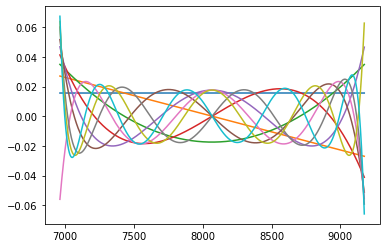

In [6]:
plt.plot(external_chis, v.T)

[]

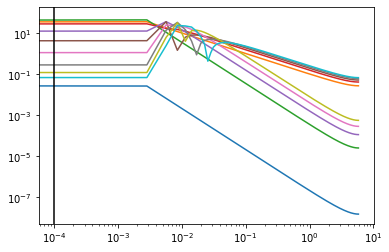

In [7]:
plt.plot(k, np.abs(v_k.T))
plt.axvline(Lambda, c='k')
plt.loglog()

# dpss to invert cov 

In [8]:
ILo_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/ILok_zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_%d.npy'%(zmin, zmax, Lambda, log2)
ILo_kappa = np.load(ILo_kappa_fname)
IHi_kappa = (I_kappa - ILo_kappa).astype(np.float64)

In [9]:
D = np.diag(external_chis)
print('computing data vector')
d = D @ IHi_kappa.T

computing data vector


In [10]:
M = (2 ** log2)
NW = (chimax - chimin) * Lambda / (2 * np.pi)    
Kmax =  int(min(2 * NW * M, M))
Kmax = int(M)
v = dpss(M = M,
         NW = NW,
         Kmax = Kmax)

In [11]:
cov = D @ mpm_eHIeHI @ D
cov_dpss = v @ cov @ v.T

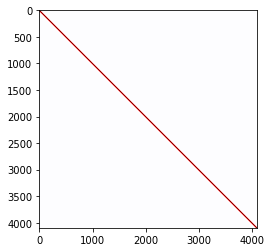

In [12]:
vb = np.max(np.abs(cov))/100
plt.imshow(cov, vmin = -vb, vmax = vb, cmap='seismic')

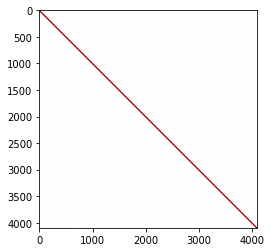

In [13]:
vb = np.max(np.abs(cov_dpss))/100
plt.imshow(cov_dpss, vmin = -vb, vmax = vb, cmap='seismic')
#much better diagonal approx?

In [14]:
print(np.min(np.diag(cov_dpss)), np.max(np.diag(cov_dpss)))

1.6005991404400473 1.854674276794551


In [15]:
d_dpss = v @ D @ IHi_kappa.T

In [16]:
diag_approx_dpss = np.diag(np.diag(cov_dpss))

In [17]:
L = np.linalg.cholesky(diag_approx_dpss)
y = np.linalg.solve(L, d_dpss)
x = np.linalg.solve(L.T, y)
diag_approx_dpss = np.einsum('ij, ji->i', d_dpss.T, x) / (ClKK + f_N0(ells))

In [18]:
from scipy.integrate import simpson
integrand =  IHi_kappa**2 / (1/external_chis**2) # [kJy^2/sr^2][Mpc^4]
diag_approx = simpson(x = external_chis,
                      y = integrand)/(ClKK + f_N0(ells)) 


In [19]:
computed_oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/snr_per_mode_scipy_zmin_%.5f_zmax_%.5f_Lambda_idx_%d_log2_%d'%(zmin, zmax, Lambda_idx, log2)
oup1_fname = computed_oup_fname + '_full.npy'
oup2_fname = computed_oup_fname + '_diag.npy'
full = np.load(oup1_fname)
diag_approx2 = np.load(oup2_fname)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


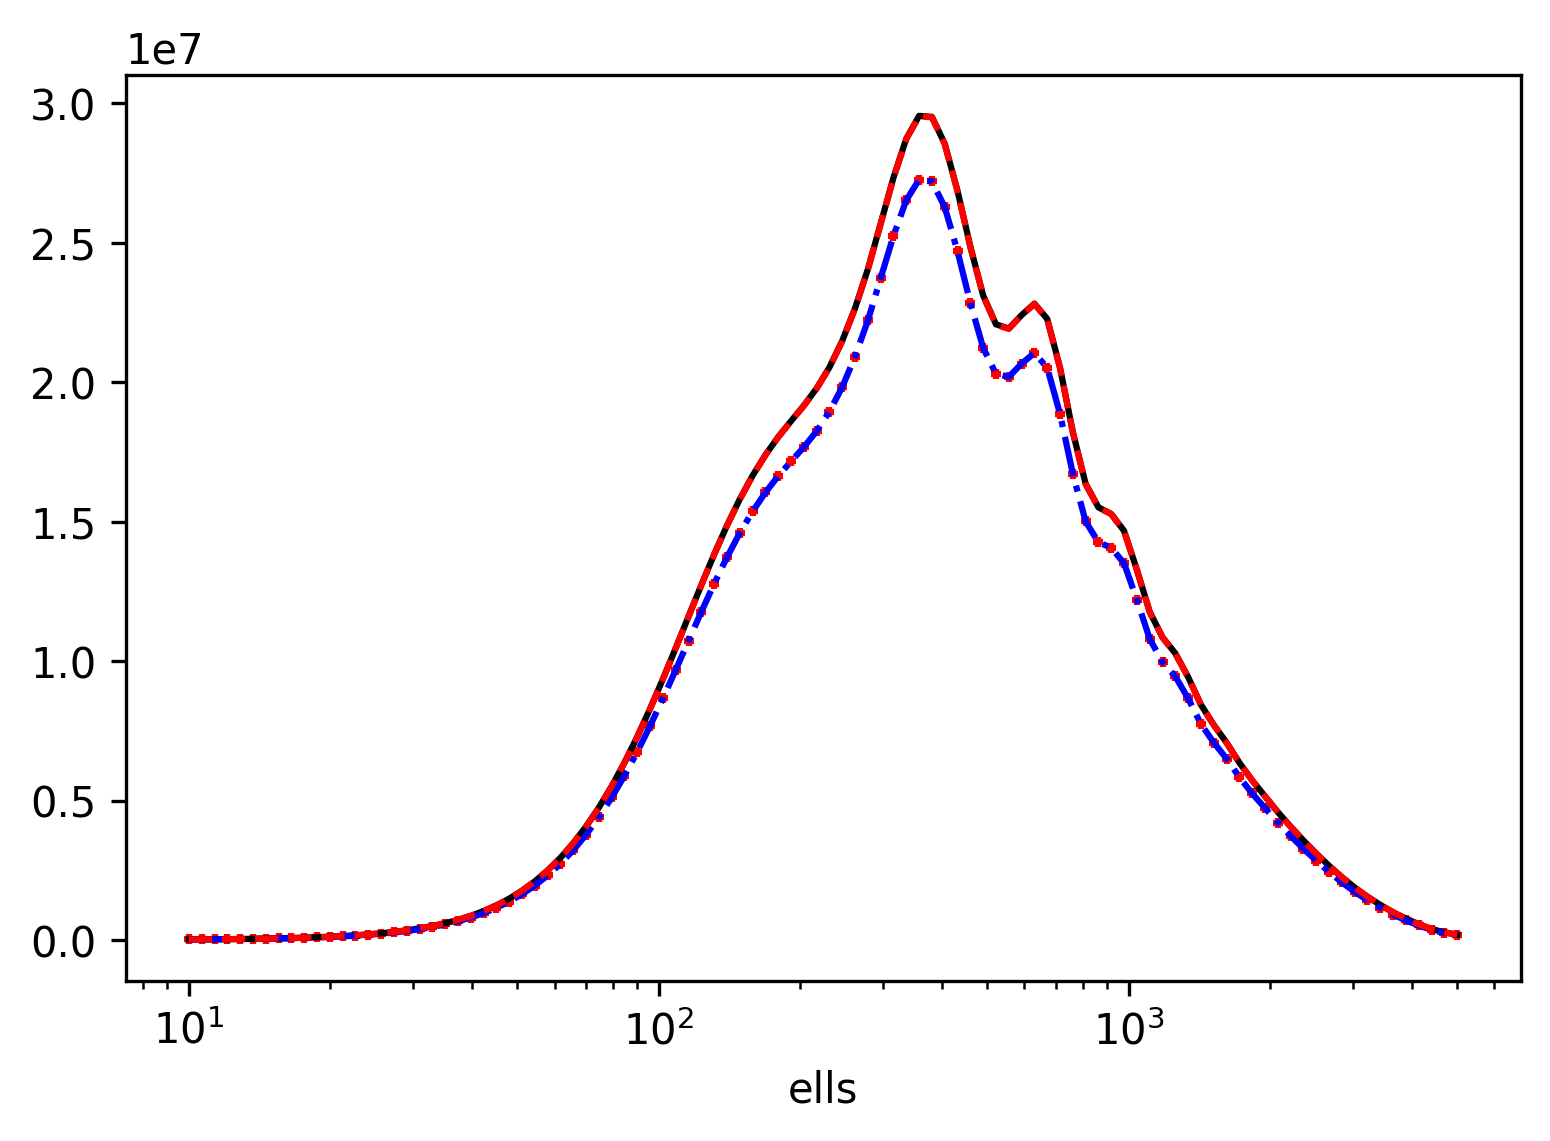

In [20]:

plt.figure(dpi=300, facecolor = 'w')
plt.plot(ells, ells**2 * full,'k')
plt.plot(ells, ells**2 * diag_approx, 'b-.')
plt.scatter(ells, ells**2 * diag_approx2, c='r',s=5, marker='+')
plt.plot(ells, ells**2 * diag_approx_dpss, 'r--')


plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)